# `qp` Demo

_Alex Malz, Phil Marshall, Eric Charles_

In this notebook we use the `qp` module to approximate some simple, standard, 1D PDFs using sets of quantiles, samples, and histograms, and assess their relative accuracy. 
We also show how such analyses can be extended to use "composite" PDFs made up of mixtures of standard distributions.

In [1]:
import numpy as np
import os
import scipy.stats as sps

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

### Requirements

To run `qp`, you will need to first install the module by following the instructions [here](https://github.com/LSSTDESC/qp/blob/u/eacharles/eac-dev-v2/docs/install.rst).

In [2]:
import qp

# Background: the `scipy.stats` module

The `scipy.stats` module is the standard for manipulating distribtions so is a natural place to start for implementing 1D PDF parameterizations.  
It allows you do define a wide variety of distibutions and uses `numpy` array broadcasting for efficiency.

### Gaussian (Normal) example

Here are some examples of things you can do with the `scipy.stats` module, using a Gaussian or Normal distribution.
`loc` and `scale` are the means and standard deviations of the underlying Gaussians.

Note the distinction between passing arguments to `norm` and passing arguments to `pdf` to access multiple distributions and their PDF values at multiple points.

In [3]:
# evaluate a single distribution's PDF at one value
print("PDF at one point for one distribution:", 
      sps.norm(loc=0, scale=1).pdf(0.5))

# evaluate a single distribution's PDF at multiple value
print("PDF at three points for one distribution:", 
      sps.norm(loc=0, scale=1).pdf([0.5, 1., 1.5]))

# evalute three distributions' PDFs at one shared value
print("PDF at one point for three distributions:", 
      sps.norm(loc=[0., 1., 2.], scale=1).pdf(0.5))

# evalute three distributions' PDFs each at one different value
print("PDF at one different point for three distributions:", 
      sps.norm(loc=[0., 1., 2.], scale=1).pdf([0.5, 1., 1.5]))

# evalute three distributions' PDFs each at four different values
# (note the change in shape of the argument)
print("PDF at four different points for three distributions:\n",
      sps.norm(loc=[0., 1., 2.], scale=1).pdf([[0.5],[1.],[1.5],[2]]))

# evalute three distributions' PDFs at each of four different values
# (note the change in shape of the argument)
print("PDF at four different points for three distributions: broadcast reversed\n",
      sps.norm(loc=[[0.], [1.], [2.]], scale=1).pdf([0.5,1.,1.5,2]))


PDF at one point for one distribution: 0.3520653267642995
PDF at three points for one distribution: [0.35206533 0.24197072 0.1295176 ]
PDF at one point for three distributions: [0.35206533 0.35206533 0.1295176 ]
PDF at one different point for three distributions: [0.35206533 0.39894228 0.35206533]
PDF at four different points for three distributions:
 [[0.35206533 0.35206533 0.1295176 ]
 [0.24197072 0.39894228 0.24197072]
 [0.1295176  0.35206533 0.35206533]
 [0.05399097 0.24197072 0.39894228]]
PDF at four different points for three distributions: broadcast reversed
 [[0.35206533 0.24197072 0.1295176  0.05399097]
 [0.35206533 0.39894228 0.35206533 0.24197072]
 [0.1295176  0.24197072 0.35206533 0.39894228]]


## The `scipy.stats` classes

In the `scipy.stats` module, all of the distributions are sub-classes of `scipy.stats.rv_continuous`.  
You make an object of a particular sub-type, and then 'freeze' it by passing it shape parameters.

In [4]:
print("This is the generic normal distribution class: ", 
      sps._continuous_distns.norm_gen)

ng = sps._continuous_distns.norm_gen()
print("This is an instance of the generic normal distribution class", 
      ng)

norm_sp = ng(loc=0, scale=1)
print("This is a frozen normal distribution, with specific paramters", 
      norm_sp, norm_sp.kwds)
print("The frozen object know what generic distribution it comes from", 
      norm_sp.dist)

This is the generic normal distribution class:  <class 'scipy.stats._continuous_distns.norm_gen'>
This is an instance of the generic normal distribution class <scipy.stats._continuous_distns.norm_gen object at 0x7fe6aaa3f210>
This is a frozen normal distribution, with specific paramters <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe6aaa3f610> {'loc': 0, 'scale': 1}
The frozen object know what generic distribution it comes from <scipy.stats._continuous_distns.norm_gen object at 0x7fe6aaa3f910>


## Properties of distributions

`scipy.stats` lets you evaluate multiple properties of distributions.  These include:
1. pdf: Probability Density Function
2. cdf: Cumulative Distribution Function
3. ppf: Percent Point Function (Inverse of CDF)
4. sf: Survival Function (1-CDF)
5. isf: Inverse Survival Function (Inverse of SF)
6. rvs: Random Variates (i.e., sampled values)
7. stats: Return mean, variance, optionally: (Fisher’s) skew, or (Fisher’s) kurtosis
8. moment: non-central moments of the distribution

In [5]:
print("PDF = ", norm_sp.pdf(0.5))  
print("CDF = ", norm_sp.cdf(0.5))
print("PPF = ", norm_sp.ppf(0.6))
print("SF  = ", norm_sp.sf(0.6))
print("ISF = ", norm_sp.isf(0.5))
print("RVS = ", norm_sp.rvs())
print("stats = ", norm_sp.stats())
print("M2  = ", norm_sp.moment(2))

PDF =  0.3520653267642995
CDF =  0.6914624612740131
PPF =  0.2533471031357997
SF  =  0.2742531177500736
ISF =  0.0
RVS =  -0.5429422861076376
stats =  (array(0.), array(1.))
M2  =  1.0


# `qp` parameterizations and visualization functionality

The next part of this notebook shows how we can extend the functionality of `scipy.stats` to implement distributions that are based on parameterizations of 1D PDFs, like histograms, interpolations, splines, or mixture models.

## Parameterizations from `scipy.stats`

`qp` automatically generates classes for all of the `scipy.stats.rv_continuous` distributions, providing feed-through access to all `scipy.stats.rv_continuous` objects but adds on additional attributes and methods specific to parameterization conversions.

In [6]:
qp.stats.keys()

odict_keys(['alpha', 'anglit', 'arcsine', 'argus', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'crystalball', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponpow', 'exponweib', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_l', 'frechet_r', 'gamma', 'gausshyper', 'genexpon', 'genextreme', 'gengamma', 'genhalflogistic', 'geninvgauss', 'genlogistic', 'gennorm', 'genpareto', 'gilbrat', 'gompertz', 'gumbel_l', 'gumbel_r', 'halfcauchy', 'halfgennorm', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kappa3', 'kappa4', 'ksone', 'kstwo', 'kstwobign', 'laplace', 'levy', 'levy_l', 'levy_stable', 'loggamma', 'logistic', 'loglaplace', 'lognorm', 'loguniform', 'lomax', 'maxwell', 'mielke', 'moyal', 'nakagami', 'ncf', 'nct', 'ncx2', 'norm', 'norminvgauss', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rayleigh', 'rdist', 'recipinvgauss', 'reciprocal', 'ric

In [7]:
help(qp.stats.lognorm_gen)

Help on class lognorm in module qp.factory:

class lognorm(qp.pdf_gen.Pdf_gen_wrap, scipy.stats._continuous_distns.lognorm_gen)
 |  lognorm(*args, **kwargs)
 |  
 |  Mixing class to extend `scipy.stats.rv_continuous` with
 |  information needed for `qp` for simple distributions.
 |  
 |  Method resolution order:
 |      lognorm
 |      qp.pdf_gen.Pdf_gen_wrap
 |      qp.pdf_gen.Pdf_gen
 |      scipy.stats._continuous_distns.lognorm_gen
 |      scipy.stats._distn_infrastructure.rv_continuous
 |      scipy.stats._distn_infrastructure.rv_generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  freeze = _my_freeze(self, *args, **kwds)
 |  
 |  moment = _moment_fix(self, n, *args, **kwds)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  name = 'lognorm'
 |  
 |  version = 0
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from qp.pdf_gen.Pdf

In [8]:
help(qp.stats.lognorm)

Help on method create in module qp.pdf_gen:

create(**kwds) method of builtins.type instance
    Create and return a `scipy.stats.rv_frozen` object using the
    keyword arguemntets provided



## Native plotting

If you have a single distribution you can plot it, the `qp.plotting.plot_native` function will find a nice way to represent the data used to construct the distribution.

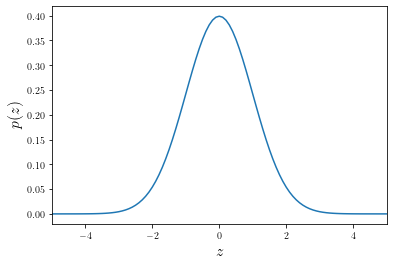

In [9]:
loc1 = np.array([[0]])
scale1 = np.array([[1]])
norm_dist1 = qp.stats.norm(loc=loc1, scale=scale1)
fig, axes = qp.plotting.plot_native(norm_dist1, xlim=(-5., 5.))

In [10]:
# fig, axes = qp.stats.norm.plot_native(norm_dist1, xlim=(-5., 5.))

## `qp` histogram (piecewise constant) parameterization

This represents a set of distributions made by interpolating a set of histograms with shared binning.
To construct this you need to give the bin edges (shape=(N)) and the bin values (shape=(npdf, N-1)).

Note that the native visual representation is different from the Normal distribution.

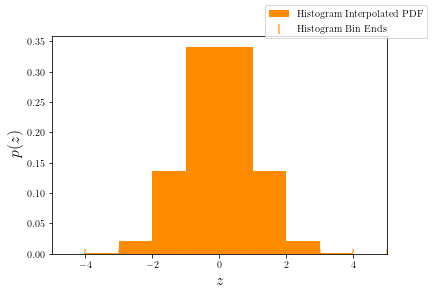

In [11]:
# Convert to a histogram by computing the bin values by taking the intergral of the CDF
xvals = np.linspace(-5, 5, 11)
cdf = norm_dist1.cdf(xvals)
bin_vals = cdf[:,1:] - cdf[:,0:-1]
# Construct histogram PDF using the bin edges and the bin values
hist_dist = qp.hist(bins=xvals, pdfs=bin_vals)
yvals = hist_dist.pdf(xvals)
# Construct a single PDF for plotting
hist_dist1 = qp.hist(bins=xvals, pdfs=np.atleast_2d(bin_vals[0]))
fig, axes = qp.plotting.plot_native(hist_dist1, xlim=(-5., 5.))
leg = fig.legend()

What if you want to evaluate a vector of input values, where each input value is different for each PDF?  In that case you need the shape of the vector of input value to match the implicit shape of the PDFs, which in this case is (2,1)

In [12]:
xvals_x = np.array([[-1.], [1.]])
yvals_x = hist_dist.pdf(xvals_x)
print ("For an input vector of shape %s the output shape is %s" % (xvals_x.shape, yvals_x.shape))

For an input vector of shape (2, 1) the output shape is (2, 1)


## `qp` quantile parameterization

This represents a set of distributions made by interpolating the locations at which various distributions reach a given set of quantiles.
To construct this you need to give the quantiles edges (shape=(N)) and the location values (shape=(npdf, N)).

Note that the native visual representation is different.

The input and output shapes are: (11,) (1, 11)


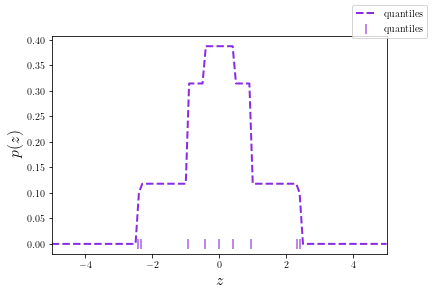

In [13]:
# Define the quantile values to compute the locations for
quants = np.linspace(0.01, 0.99, 7)
# Compute the corresponding locations
locs = norm_dist1.ppf(quants)
# Construct the distribution using the quantile value and locations
quant_dist = qp.quant(quants=quants, locs=locs)
quant_vals = quant_dist.pdf(xvals)
print("The input and output shapes are:", xvals.shape, quant_vals.shape)
# Construct a single PDF for plotting
quant_dist1 = qp.quant(quants=np.atleast_1d(quants), locs=np.atleast_2d(locs[0]))
fig, axes = qp.plotting.plot_native(quant_dist1, xlim=(-5., 5.), label="quantiles")
leg = fig.legend()

In [14]:
print(quants)
print(quant_dist.dist.quants)

[0.01       0.17333333 0.33666667 0.5        0.66333333 0.82666667
 0.99      ]
[0.         0.01       0.17333333 0.33666667 0.5        0.66333333
 0.82666667 0.99       1.        ]


## `qp` interpolated parameterization

This represents a set of distributions made by interpolating a set of x and y values. 
To construct this you need to give the x and y values (both of shape=(npdf, N))

Note that the native visual representation is pretty similar to the original one for the Gaussian.

The input and output shapes are: (11,) (1, 11)


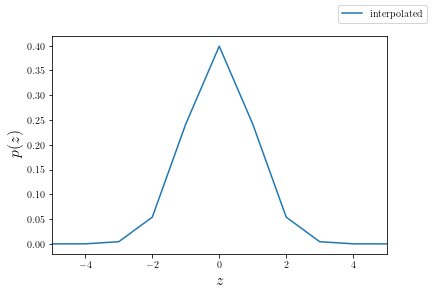

In [15]:
# Define the x-grid locations
xvals = np.linspace(-5, 5, 11)
# Compute the corresponding y values
yvals = norm_dist1.pdf(xvals)
# Construct the PDFs using the x grid and y values
interp_dist = qp.interp(xvals=xvals, yvals=yvals)
interp_vals = interp_dist.pdf(xvals)
print("The input and output shapes are:", xvals.shape, interp_vals.shape)
# Construct a single PDF for plotting
interp_dist1 = qp.interp(xvals=xvals, yvals=np.atleast_2d(yvals[0]))
fig, axes = qp.plotting.plot_native(interp_dist1, xlim=(-5., 5.), label="interpolated")
leg = fig.legend()

## `qp` spline parameterization constructed from kernel density estimate (samples) parameterization

This represents a set of distributions made by producing a kernel density estimate from a set of samples.

To construct this you need to give the samples edges (shape=(npdf, Nsamples)).

Note again that the the native visual represenation is different.

/Users/echarles/software/vro/qp/qp/spline_pdf.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(spl, limits[0], limits[1], **kwargs)[0]


The input and output shapes are: (11,) (2, 51)


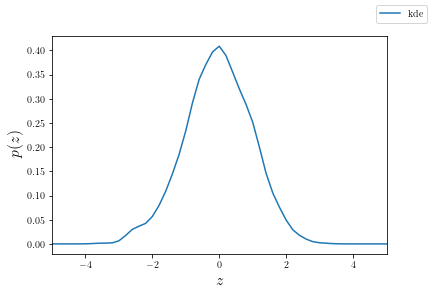

In [16]:
# Take 100 random samples from each of 2 PDFs
samples = norm_dist1.rvs(size=(2, 1000))
# Define points at which to evaluate the kernal density estimate (KDE)
xvals_kde = np.linspace(-5., 5., 51)
# Use a utility function to construct the KDE, sample it, and they construct a spline
kde_dist = qp.spline_from_samples(xvals=xvals_kde, samples=samples)
kde_vals = kde_dist.pdf(xvals_kde)
print("The input and output shapes are:", xvals.shape, kde_vals.shape)
# Construct a single PDF for plotting
kde_dist1 = qp.spline_from_samples(xvals=xvals_kde, samples=np.atleast_2d(samples[0]))
fig, axes = qp.plotting.plot_native(kde_dist1, xlim=(-5., 5.), label="kde")
leg = fig.legend()

## `qp` spline parameterization

This represents a set of distributions made building a set of splines. Though the parameterization is defined by the spline knots, you can construct this from x and y values (both of shape=(npdf, N)).

Note that the native visual representation is pretty similar to the original one for the Gaussian.

Note also that the spline knots are stored.

The input and output shapes are: (11,) (1, 11)
Spline knots [[-5. -5. -5. -5. -3. -2. -1.  0.  1.  2.  3.  5.  5.  5.  5.]] [[ 1.48609459e-06  1.68880388e-03 -5.05824770e-03  2.11574348e-02
   2.37684221e-01  4.79319775e-01  2.37684221e-01  2.11574348e-02
  -5.05824770e-03  1.68880388e-03  1.48609459e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]] [[3]]
(1, 15)


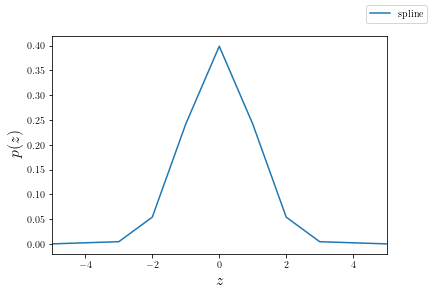

In [17]:
# To make a spline you need the spline knots, you can get those from the xval, yval values
splx, sply, spln = qp.spline_gen.build_normed_splines(np.expand_dims(xvals,0), yvals)
spline_dist_orig = qp.spline(splx=splx, sply=sply, spln=spln)
# Or we can do these two steps together using one function
spline_dist = qp.spline_from_xy(xvals=np.expand_dims(xvals,0), yvals=yvals)
spline_vals = spline_dist.pdf(xvals)
print("The input and output shapes are:", xvals.shape, spline_vals.shape)
print("Spline knots", spline_dist.dist.splx, spline_dist.dist.sply, spline_dist.dist.spln)
# Construct a single PDF for plotting
spline_dist1 = qp.spline_from_xy(xvals=np.atleast_2d(xvals), yvals=np.atleast_2d(yvals))
print(spline_dist1.dist.splx.shape)
fig, axes = qp.plotting.plot_native(spline_dist1, xlim=(-5., 5.), label="spline")
leg = fig.legend()

## Overplotting

You can visually compare the represenations by plotting them all on the same figure.

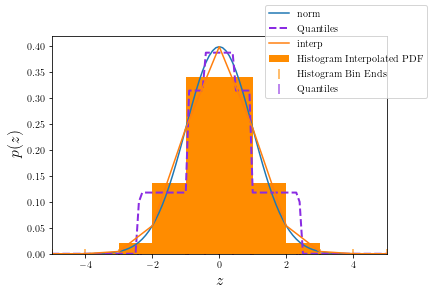

In [18]:
fig, axes = qp.plotting.plot_native(norm_dist1, xlim=(-5., 5.), label="norm")
qp.plotting.plot_native(hist_dist1, axes=axes)
qp.plotting.plot_native(quant_dist1, axes=axes)
qp.plotting.plot_native(interp_dist1, axes=axes, label="interp")
# qp.plotting.plot_native(kde_dist1, axes=axes)
# qp.plotting.plot_native(spline_dist1, axes=axes, label="spline")
leg = fig.legend()

# The `qp.Ensemble` Class

This is the basic element of `qp` - an object representing a set of probability density functions. This class is stored in the module `ensemble.py`.  

To create a `qp.Ensemble` you need to specify the class used to represent the PDFs, and provide that data for the specific set of PDFs.  

## Ensembles of distributions

`qp` no longer distinguishes between distributions and ensembles thereof -- a single distribution is just a special case of an ensemble with only one member, which takes advantage of computational efficiencies in `scipy`.
The shape of the array returned by a call to the pdf function of a distribution depends on the shape of the parameters and evaluate points.  

For distributions that take multiple input arrays, `qp` uses te convention that the rows are the individual distributions and the columns are the values of the parameters defining the distributions under a known parameterization.

In [ ]:
# This is a trivial extension, with the number of pdfs as a member of the `scipy.stats.norm_gen` distribution.
loc = np.array([[0],[1]])
scale = np.array([[1],[1]])
norm_dist = qp.stats.norm(loc=loc, scale=scale)
xvals = np.linspace(-5, 5, 51)
yvals = norm_dist.pdf(xvals)
print("This object represents %i pdfs" % norm_dist.npdf)
print("The input and output shapes are:", xvals.shape, yvals.shape)

In [ ]:
print ("For an input vector of shape %s the output shape is %s" % (xvals.shape, yvals.shape))

In [ ]:
# In this case we return an array were the rows are the evaluation points and the columns the different PDFs
vector_pdf = qp.stats.norm(loc=[0., 1., 2], scale=1.)
vector_pdf.pdf([[0.], [0.5]])

In [ ]:
# This is the same, except we use `numpy.expand_dims` to shape the input array of evaluation points
vector_pdf = qp.stats.norm(loc=[0., 1., 2], scale=1.)
vector_pdf.pdf(np.expand_dims(np.array([0., 0.5]), -1))

In [ ]:
# In this case we return an array were the rows are pdfs and the columns the evaluation points
vector_pdf = qp.stats.norm(loc=[[0.], [1.], [2]], scale=1.)
vector_pdf.pdf([0., 0.5])

In [ ]:
# This is the same, except we use `numpy.expand_dims` to shape the input array of pdf parameters
vector_pdf = qp.stats.norm(loc=np.expand_dims([0., 1., 2], -1), scale=1.)
vector_pdf.pdf([0., 0.5])

Here we will great a 100 Gaussians with means distributed between -1 and 1, and widths distributed between 0.9 and 1.1.

In [ ]:
locs = 2* (np.random.uniform(size=(100,1))-0.5)
scales = 1 + 0.2*(np.random.uniform(size=(100,1))-0.5)
ens_n = qp.Ensemble(qp.stats.norm, data=dict(loc=locs, scale=scales))

### Using the ensemble

All of the methods of the distributions (`pdf`, `cdf` etc.) work the same way for an ensemble as for underlying classes. 

To isolate a single distribution in the ensemble, use the square brackets operator `[]`.

In [ ]:
vals_n = ens_n.pdf(xvals)
print("The shapes are: ", xvals.shape, vals_n.shape)
fig, axes = qp.plotting.plot_native(ens_n[15], xlim=(-5.,5.))

### Converting the ensemble

The `qp.Ensemble.convert_to` function lets you convert ensembles to other representations. To do this you have to provide the original ensemble, the class you want to convert to, and any some keyword arguments to specify details about how to convert to the new class, here are some examples.

In [ ]:
bins = np.linspace(-5, 5, 11)
quants = np.linspace(0.01, 0.99, 7)
print("Making hist")
ens_h = ens_n.convert_to(qp.hist_gen, bins=bins)
print("Making interp")
ens_i = ens_n.convert_to(qp.interp_gen, xvals=bins)
print("Making spline")
ens_s = ens_n.convert_to(qp.spline_gen, xvals=bins, method="xy")
#print("Making spline from samples")
#ens_s = ens_n.convert_to(qp.spline_gen, xvals=bins, samples=1000, method="samples")
print("Making quants")
ens_q = ens_n.convert_to(qp.quant_gen, quants=quants)
print("Making mixmod")
ens_m = ens_n.convert_to(qp.mixmod_gen, samples=1000, ncomps=3)
#print("Making flexcode")
#ens_f = ens_n.convert_to(qp.flex_gen, grid=bins, basis_system='cosine')

The `qp.convert` function also works the more or less the same way, but with slightly different syntax, where you can use the name of the class instead of the class object.  

In [ ]:
print("Making hist")
ens_h2 = qp.convert(ens_n, "hist", bins=bins)
print("Making interp")
ens_i2 = qp.convert(ens_n, "interp", xvals=bins)
print("Making spline")
ens_s2 = qp.convert(ens_n, "spline", xvals=bins, method="xy")
print("Making quants")
ens_q2 = qp.convert(ens_n, "quant", quants=quants)
print("Making mixmod")
ens_m2 = qp.convert(ens_n, "mixmod", samples=1000, ncomps=3)


# Comparing Parametrizations

`qp` supports quantitative comparisons between different distributions, across parametrizations.

## Qualitative Comparisons: Plotting

Let's visualize the PDF object in order to original and the other representaions.  The solid, black line shows the true PDF evaluated between the bounds.  The green rugplot shows the locations of the 1000 samples we took.  The vertical, dotted, blue lines show the percentiles we asked for, and the hotizontal, dotted, red lines show the 10 equally spaced bins we asked for.  Note that the quantiles refer to the probability distribution *between the bounds*, because we are not able to integrate numerically over an infinite range. Interpolations of each parametrization are given as dashed lines in their corresponding colors.  Note that the interpolations of the quantile and histogram parametrizations are so close to each other that the difference is almost imperceptible!

In [ ]:
fig, axes = qp.plotting.plot_native(ens_n[15], xlim=(-5.,5.))
qp.plotting.plot_native(ens_h[15], axes=axes)
qp.plotting.plot_native(ens_q[15], axes=axes, label='quantile')
qp.plotting.plot_native(ens_i[15], axes=axes, label='interp')
# qp.plotting.plot_native(ens_s[15], axes=axes, label='spline')
qp.plotting.plot_native(ens_m[15], axes=axes, label='mixmod')
#qp.qp_plot_native(ens_f[15], axes=axes, label='flex')
leg = fig.legend()


We can also interpolate the function onto an evenly spaced grid point and cache those values with the `gridded` function.

In [ ]:
grid = np.linspace(-3., 3., 100)
gridded = ens_n.pdf(grid)

In [ ]:
cached_gridded = ens_n.gridded(grid)[1]
check = gridded - cached_gridded
print(check.min(), check.max())

## Quantitative Comparisons

In [ ]:
symm_lims = np.array([-1., 1.])
all_lims = [symm_lims, 2.*symm_lims, 3.*symm_lims]

Next, let's compare the different parametrizations to the truth using the Kullback-Leibler Divergence (KLD).  The KLD is a measure of how close two probability distributions are to one another -- a smaller value indicates closer agreement.  It is measured in units of bits of information, the information lost in going from the second distribution to the first distribution.  The KLD calculator here takes in a shared grid upon which to evaluate the true distribution and the interpolated approximation of that distribution and returns the KLD of the approximation relative to the truth, which is not in general the same as the KLD of the truth relative to the approximation.  Below, we'll calculate the KLD of the approximation relative to the truth over different ranges, showing that it increases as it includes areas where the true distribution and interpolated distributions diverge.

In [ ]:
# for a single pair of pdfs. (the 15th in each ensemble)
klds = ens_n.kld(ens_s, limits=all_lims[0])[15]
print(klds)

In [ ]:
# Loop over all the other ensemble types
ensembles = [ens_n, ens_h, ens_i, ens_s, ens_q, ens_m]
for ensemble in ensembles[1:]:
    D = []
    for lims in all_lims:
        klds = ens_n.kld(ensemble, limits=lims)
        D.append("%.2e +- %.2e" % (klds.mean(), klds.std()))
    print(ensemble.gen_class.name + ' approximation: KLD over 1, 2, 3, sigma ranges = ' + str(D))

The progression of KLD values should follow that of the root mean square error (RMSE), another measure of how close two functions are to one another.  The RMSE also increases as it includes areas where the true distribution and interpolated distribution diverge.  Unlike the KLD, the RMSE is symmetric, meaning the distance measured is not that of one distribution from the other but of the symmetric distance between them.

In [ ]:
for ensemble in ensembles[1:]:
    D = []
    for lims in all_lims:
        rmses = ens_n.rmse(ensemble, limits=lims)
        D.append("%.2e +- %.2e" % (rmses.mean(), rmses.std()))
    print(ensemble.gen_class.name + ' approximation: RMSE over 1, 2, 3, sigma ranges = ' + str(D))

Both the KLD and RMSE metrics suggest that the quantile approximation is better in the high density region, but samples work better when the tails are included. We might expect the answer to the question of which approximation to use to depend on the application, and whether the tails need to be captured or not.

## Storing and retreiving ensembles

You can store and retrieve ensembles from disk using the `qp.Ensemble.write_to` and `qp.Ensemble.read_from` methods.

These work in two steps, first they convert the Ensemble data to `astropy.table` objects, and then they write the tables.  This means you can store the data in any format support by `astropy`.

In [ ]:
tabs = ens_n.build_tables()
print(tabs.keys())
print()
print("Meta Data")
print(tabs['meta'])
print()
print("Object Data")
print(tabs['data'])

Here is a loopback test showing that we get the same results before and after a write/read cycle.

In [ ]:
suffix_list = ['_n', '_h', '_i', '_s', '_q', '_m']
filetypes = ['fits', 'hdf5']
for ens, suffix in zip(ensembles, suffix_list):
    for ft in filetypes:

        outfile = "test%s.%s" % (suffix, ft)

        pdf_1 = ens.pdf(bins)        
        ens.write_to(outfile)
        ens_r = qp.read(outfile)
        pdf_2 = ens_r.pdf(bins)

        check = pdf_1 - pdf_2
        print(suffix, ft, check.min(), check.max())

        os.unlink(outfile)

Finally, we can compare the moments of each approximation and compare those to the moments of the true distribution.

In [ ]:
which_moments = range(3)
all_moments = []
for ens in ensembles:
    moments = []
    for n in which_moments:
        moms = qp.metrics.calculate_moment(ens, n, limits=(-3, 3))
        moments.append("%.2e +- %.2e" % (moms.mean(), moms.std()))
    all_moments.append(moments)
    
print('moments: '+str(which_moments))
for ens, mom in zip(ensembles, all_moments):
    print(ens.gen_class.name+': '+str(mom))